In [1]:
from utils import create_or_load_pickle, ignore_warnings
import numpy as np
from scipy.io import wavfile 
import matplotlib.pyplot as plt
%matplotlib inline
ignore_warnings()

これまでは訓練データを数値ベクトル化することが簡単であったが，音楽はそうはいかない．  
ここでは音楽ジャンル分類問題を扱う．  
音楽データをその特性をとらえることができる数値に変換するにはどうすればいいか，見ていく．

# 本章のロードマップ
音楽(MP3ファイルを想定)のジャンル分類問題では，以下のようなことが問題になってくる．
- サウンドベースの特徴量の取得
- 多クラスへの分類
- 分類期のパフォーマンス評価の手法

# 音楽データを取得する
GTZANというデータセットを使用する．  
URLは http://opihi.cs.uvic.ca/sound/genres.tar.gz  
10個のジャンルが存在するが，ここでは「クラシック，ジャズ，カントリー，ポップ，ロック，メタル」を用いることにする．  
各ジャンルごとに100曲のデータが存在し，それぞれ最初の30秒だけから構成される．

## WAVフォーマットに変換する
ジャンル分類に利用するならば，MP3よりもWAVで扱う方が都合が良いので変換しておく．  
ファイルの変換には[AV Audio Converter](https://www.audio4fun.com/player/audio-converter.htm)が便利だが，音波生成などの便利機能をコマンドライン上で利用できる[sox](https://sourceforge.net/projects/sox/files/sox/14.4.2/)も使える．  
soxは，環境変数を通すことで使用できるようになる．  
ここではサンプリングレート22050Hz，モノラルでWAVファイルに変換する．（そうしないとデータが二次元になって面倒）  
wavはscipyによって読み込むことができる．

In [4]:
wave_filename = "./data/ch09/sample.wav"
sample_rate, X = wavfile.read(wave_filename)

# 音楽を見る
音楽のスペクトログラムを描画する．  
スペクトログラムは，音楽の周波数を視覚化するための画像表現．  
横軸は時間，縦軸は周波数，色の濃さはその時間，その周波数の信号強度を示す．  
matplotlibのspecgram()という関数を利用する．  

22050 (941184,)


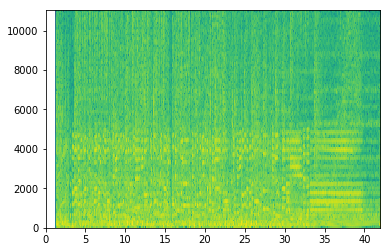

In [7]:
print(sample_rate, X.shape)
spec = plt.specgram(X, Fs=sample_rate, xextent=(0, len(X) // sample_rate))

このようにしてスペクトログラムを表示すると，例えばメタルは全体的に濃く，ジャズは薄いといったパターンが見て取れる．  
メタルとジャズの分類は簡単にできそうだが，ロックとカントリー音楽のペアなどは難しい．

## 音楽をサイン波に分解する
周波数ごとの強度を分類器に入力する特徴量としてみたい．  
そのために，高速フーリエ変換(FFT)を行う．簡単な仕組みについては[この記事](https://www.yukisako.xyz/entry/fourier-transform)  
FFTの理論はここでは述べず，どのようなことができるのかを説明．  

例として，2つのサイン波のフーリエ変換について見てみる．  
まずは周波数の違う2つのサイン波をsoxで作成

``` bash
> sox --null -r 22050 sine_a.wav synth 0.2 sine 400  
> sox --null -r 22050 sine_b.wav synth 0.2 sine 3000
```
400Hzの波を3000Hzの波の半分のボリュームにし，2つを混ぜ合わせる．  
``` bash
> sox --combine mix --volume 1 sine_b.wav --volume 0.5 sine_a.wav sine_mix.wav
```
それぞれの波形とフーリエ変換後のスペクトルを見てみる．

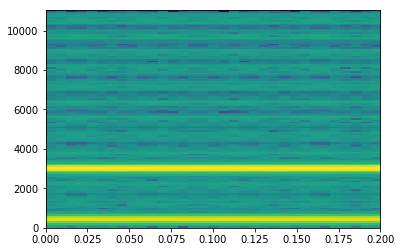

In [14]:
sin_a_path = "./data/ch09/sin/sine_a.wav"
sin_b_path = "./data/ch09/sin/sine_b.wav"
sin_mix_path = "./data/ch09/sin/sine_mix.wav"

sr, xa = wavfile.read(sin_a_path)
_, xb = wavfile.read(sin_b_path)
_, xmix = wavfile.read(sin_mix_path)

spec_a = plt.specgram(xa, Fs=sr, xextent=(0, float(len(xa)) / sr))
spec_b = plt.specgram(xb, Fs=sr, xextent=(0, float(len(xb)) / sr))
spec_mix = plt.specgram(xmix, Fs=sr, xextent=(0, float(len(xmix)) / sr))